## Qiskit ADAPT-VQE tutorial

ADAPT-VQE is a variation of the original VQE algorithm, which grows the ansatz at each iteration by selecting operators from an operator pool. This typically results in shorter depth circuits than fixed-depth ansatze designed for VQE. This algorithm was first introduced in https://arxiv.org/abs/1812.1117. For a ground state estimation problem from the quantum chemistry domain, steps are outlined as follows.

1. We find the fermionic Hamiltonian by defining the molecular geometry, and map it onto qubit representation using a mapper such as the Jordan-Wigner transform. 
2. The quantum computer is typically initiated in the Hartree-Fock state under the same transformation as an estimate to the ground state energy.
3. We define the pool of operators as the set of excitation operators generated by the UCC ansatz. Note that under the Jordan-Wigner transformation, these operators are anti-Hermitian.
4. Until the algorithm terminates:
    - we compute the gradient of each operator from the pool and select the operator with the maximum gradient,
    - grow the ansatz with $\textrm{exp}(j*\theta_i*\textrm{operator}_i)$,
    - run VQE over all parameters $\theta_i$,
    - and terminate the algorithm if the gradient of all operators from the pool are smaller than some threshold (convergence) or if we reach the maximum number of allowed iterations.

We note the following variants of the ADAPT-VQE algorithm:
- A hardware-efficient variant called qubit-ADAPT-VQE, which reduces the circuit depth by constructing the pool directly with individual Pauli operators: https://arxiv.org/abs/1911.10205.
- A utility scale ADAPT-VQE experiment for the Schwinger model using up to 100 qubits of IBM Quantum devices: https://arxiv.org/abs/2308.04481.

In the following, we define the problem and implement the algorithm using Qiskit Patterns formalism in 4 steps:
1. Map classical inputs to a quantum problem
2. Optimize problem for quantum execution
3. Execute using Qiskit Primitives
4. Post-process and return result in classical format



### Define the molecule
We start by defining the molecule using ``pyscf``. As an example we select LiH and build it by providing its geometry.
Code to generate additional molecules can be found in ``Example_Molecules.ipynb`` at https://learning.quantum.ibm.com/course/quantum-chemistry-with-vqe/.

In [1]:
from pyscf import ao2mo, gto, mcscf, scf

# LiH
distance = 1.59
mol = gto.Mole()
mol.build(
    verbose=0,
    atom=[["Li", (0, 0, 0)], ["H", (0, 0, distance)]],
    basis="sto-6g",
    spin=0,
    charge=0,
    symmetry="Coov",    
    )


In [2]:
print(f"Nuclear energy: {mol.energy_nuc()}")
print(f"Electronic energy: {mol.energy_elec()[0]}")
print(f"Total energy: {mol.energy_tot()}")
print(f"Total energy - nuclear energy: {mol.energy_tot() - mol.energy_nuc()}")

Nuclear energy: 0.998447567773585


/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Electronic energy: -8.950577623117868
Total energy: -7.952130055344282
Total energy - nuclear energy: -8.950577623117868


### Generate the fermionic Hamiltonian
We generate the fermionic Hamiltonian consisting of creation and annihilation operators. Single-electron (h1e) and double-electron (h2e) operators are extracted below.

In [3]:
mf = scf.RHF(mol)
E1 = mf.kernel()
mx = mcscf.CASCI(mf, ncas=5, nelecas=(1, 1))
cas_space_symmetry = {"A1": 3, "E1x": 1, "E1y": 1}
mo = mcscf.sort_mo_by_irrep(mx, mf.mo_coeff, cas_space_symmetry)
E2 = mx.kernel(mo)[:2]

h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)

## Qiskit Patterns Step 1: Map classical inputs to a quantum problem
We will map the Hamiltonian operator, the initial state and the operator pool of the ansatz to a quantum problem using the Jordan-Wigner transform. We also define functions to compute gradients and the cost of these operators.

### Map the fermionic Hamiltonian to a qubit operator
Now, we map the fermionic Hamiltonian to a qubit Hamiltonian using the Jordan-Wigner transformation. Here, we implement the Jordan-Wigner mapper directly using only ``PySCF``, ``numpy``, and ``Qiskit``, as implemented in https://learning.quantum.ibm.com/course/quantum-chemistry-with-vqe/the-hamiltonian.

In [4]:
#------------Loading packages and defining necessary functions for mapping the fermionic Hamiltonian to one usable on IBM Quantum Systems---------------------

import numpy as np
from qiskit.quantum_info import SparsePauliOp


def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng


def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                l, r = "I" * (n - 1), ""
            elif p == n - 1:
                l, r = "", "Z" * (n - 1)
            else:
                l, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(l + "X" + r, 0.5), (l + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list


def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

In [5]:
H = build_hamiltonian(ecore, h1e, h2e)
print(f"The Hamiltonian consists of {len(H)} {2 * mx.ncas}-qubit Pauli operators.")

accuracy of Cholesky decomposition  1.1796119636642288e-16
The Hamiltonian consists of 276 10-qubit Pauli operators.


### Initial state
A common strategy is to initiate the quantum computer to the Hartree-Fock state, which we implement using the functions below.

In [6]:
from qiskit import QuantumCircuit


def hartree_fock_bitstring(num_spatial_orbitals: int, num_particles: tuple[int, int]) -> list[bool]:
    """Compute the bitstring representing the Hartree-Fock state for the specified system.
    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.
    Returns:
        The bitstring representing the state of the Hartree-Fock state as array of bools.
    Raises:
        ValueError: If the total number of particles is larger than the number of orbitals.
    """
    # validate the input
    assert num_spatial_orbitals >= 1
    num_alpha, num_beta = num_particles

    if any(n > num_spatial_orbitals for n in num_particles):
        raise ValueError("# of particles must be less than or equal to # of orbitals.")

    half_orbitals = num_spatial_orbitals
    bitstr = np.zeros(2 * num_spatial_orbitals, bool)
    bitstr[:num_alpha] = True
    bitstr[half_orbitals : (half_orbitals + num_beta)] = True

    return bitstr.tolist()


def hartree_fock_circuit(num_spatial_orbitals: int, num_particles: tuple[int, int]) -> QuantumCircuit:
    """Prepare the quantum circuit under the Jordan-Wigner transform from the bitstring representing 
    the Hartree-Fock state for the specified system.
    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.
    Returns:
        The quantum circuit preparing the Hartree-Fock state under the Jordan-Wigner transform.
    """
    # Get the Hartree-Fock initial state in boolean bitstring representation
    hf_bitstring = hartree_fock_bitstring(num_spatial_orbitals, num_particles)

    # Under the Jordan-Wigner transform, corresponding circuit is found by flipping the qubits by an 
    # X-gate as indicated by the boolean list
    hf_circuit = QuantumCircuit(len(hf_bitstring))
    for i, hf_bit in enumerate(hf_bitstring):
        if hf_bit:
            hf_circuit.x(i)
    
    return hf_circuit


We build the circuit preparing the Hartree-Fock state in Jordan-Wigner transform.

/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


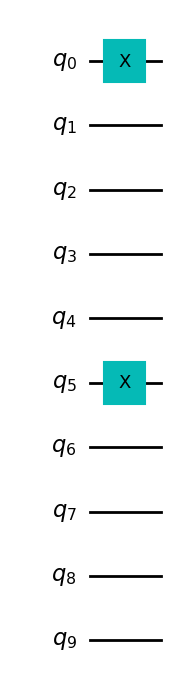

In [7]:
num_spatial_orbitals = mx.ncas
num_particles = mx.nelecas

hf_circuit = hartree_fock_circuit(num_spatial_orbitals, num_particles)
hf_circuit.draw(output = 'mpl')

### Operator pool
We define the set of operators as the single and double excitation operators generated by the UCC ansatz. These operators are also represented under the Jordan-Wigner transform. Note that this results in anti-Hermitian excitation operators, but we multiply them with the complex phase 1j so that they appear Hermitian.

In [8]:
def single_excitation(num_spatial_orbitals: int, num_particles: tuple[int, int], mapping="jordan-wigner") -> list[SparsePauliOp]:
    """Compute single excitation operators under the Jordan-Wigner transform 
    (up to complex coefficient 1j, such that they appear Hermitian instead of anti-Hermitian).
    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.
    Returns:
        A list of single excitation operators under the Jordan-Wigner transform.
    """
    C, D = creators_destructors(2 * num_spatial_orbitals, mapping="jordan_wigner")

    num_alpha, num_beta = num_particles
    half_orbitals = num_spatial_orbitals
    indices_alpha = list(range(num_alpha))
    indices_beta = list(range(half_orbitals, (half_orbitals + num_beta)))

    single_excitation_operators = []

    for p in indices_alpha:
        for r in range(p + 1, half_orbitals):
            if r not in indices_alpha:
                exc = 1j * (C[p] @ D[r] - C[r] @ D[p]).simplify()
                single_excitation_operators.append(exc)

    for p in indices_beta:
        for r in range(p + 1, 2 * half_orbitals):
            if r not in indices_beta:
                exc = 1j * (C[p] @ D[r] - C[r] @ D[p]).simplify()
                single_excitation_operators.append(exc)
    
    return single_excitation_operators

In [9]:
def double_excitation(num_spatial_orbitals: int, num_particles: tuple[int, int], mapping="jordan-wigner") -> list[SparsePauliOp]:
    """Compute double excitation operators under the Jordan-Wigner transform 
    (up to complex coefficient 1j, such that they appear Hermitian instead of anti-Hermitian).
    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.
    Returns:
        A list of single excitation operators under the Jordan-Wigner transform.
    """
    C, D = creators_destructors(2 * num_spatial_orbitals, mapping="jordan_wigner")

    num_alpha, num_beta = num_particles
    half_orbitals = num_spatial_orbitals
    indices_alpha = list(range(num_alpha))
    indices_beta = list(range(half_orbitals, (half_orbitals + num_beta)))

    double_excitation_operators = []

    # Both excitations from alpha
    if len(indices_alpha) > 1:
        # from these indices
        for p in indices_alpha:
            for r in range(p + 1, num_alpha):
                # to these indices
                for a in range(indices_alpha[-1] + 1, half_orbitals):
                    for b in range(a + 1, half_orbitals):
                        exc = 1j * (C[p] @ C[r] @ D[a] @ D[b] - C[b] @ C[a] @ D[r] @ D[p]).simplify()
                        double_excitation_operators.append(exc)

    # Both excitations from beta
    if len(indices_beta) > 1:
        # from these indices
        for p in indices_beta:
            for r in range(p + 1, half_orbitals + num_beta):
                # to these indices
                for a in range(indices_beta[-1] + 1, 2 * half_orbitals):
                    for b in range(a + 1, 2 * half_orbitals):
                        exc = 1j * (C[p] @ C[r] @ D[a] @ D[b] - C[b] @ C[a] @ D[r] @ D[p]).simplify()
                        double_excitation_operators.append(exc)

    # One excitation from alpha, one from beta
    # from these indices
    for p in indices_alpha:
        for r in indices_beta:
            # to these indices
            for a in range(indices_alpha[-1] + 1, half_orbitals):
                for b in range(indices_beta[-1] + 1, 2 * half_orbitals):
                    exc = 1j * (C[p] @ C[r] @ D[a] @ D[b] - C[b] @ C[a] @ D[r] @ D[p]).simplify()
                    double_excitation_operators.append(exc)
    
    return double_excitation_operators


In [10]:
num_spatial_orbitals = mx.ncas
num_particles = mx.nelecas

single_excitation_operators = single_excitation(num_spatial_orbitals, num_particles)
double_excitation_operators = double_excitation(num_spatial_orbitals, num_particles)

excitation_pool = single_excitation_operators + double_excitation_operators
print(f"The excitation pool consists of {len(excitation_pool)} operators.")

The excitation pool consists of 24 operators.


### Gradient of the excitation operators
We compute the gradient of all excitation operators in the pool given the current optimized ansatz. 

In [11]:
def compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params=None):
    """
    Computes the gradients for all available excitation operators.
    Args:
        ansatz: ansatz built so far.
        hamiltonian: Hamiltonian after qubit mapping in SparsePauliOp format.
        excitation_pool: anti-Hermitian operators whose gradients need to be computed.
        estimator: an instance of the Qiskit Estimator primitive.
        params: parameters to be assigned to the ansatz, if any.
    Returns:
        List of computed gradients in the same order as the excitation operators in the excitation pool.
    """
    # The excitations operators are applied later as exp(i*theta*excitation).
    # For this commutator, we need to explicitly pull in the imaginary phase.
    if params is not None:
        ansatz_opt = ansatz.assign_parameters(params)
    else:
        ansatz_opt = ansatz
    # We recall that 1j was omitted earlier for the anti-Hermitian operators.
    commutators = [1j * (hamiltonian @ exc - exc @ hamiltonian) for exc in excitation_pool]
    ansatz_list = [ansatz_opt for _ in range(len(commutators))]
    gradients = estimator.run(ansatz_list, commutators).result().values

    return gradients

### Cost function
We define the cost function as the expectation value of the Hamiltonian operator given an ansatz with its parameters.

In [12]:
def cost_func(params, ansatz, H, estimator):
    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
    return energy

## Qiskit Patterns Step 2: Optimize problem for quantum execution

We start by selecting a backend for execution.

In [13]:
# To run on hardware:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
# backend = service.get_backend('ibmq_kolkata')

Here we optimize the circuit for running on a real backend by specifying the optimization_level and adding dynamical decoupling. The code below generates a mass manager using preset pass managers from qiskit.transpiler.

In [14]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling, ConstrainedReschedule
from qiskit.circuit.library import XGate

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target), 
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        PadDynamicalDecoupling(target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment)
    ]
)

Now we use the pass manager on the initial state. We can similarly apply device layout characteristics to the Hamiltonian to get a more physical representation.

In [15]:
hf_circuit_ibm = pm.run(hf_circuit)
H_ibm = H.apply_layout(hf_circuit_ibm.layout) 
excitation_pool_ibm = [exc.apply_layout(hf_circuit_ibm.layout) for exc in excitation_pool]

## Qiskit Patterns Step 3: Execute using Qiskit Primitives
Before we execute on the selected hardware, it is a good idea to use a simulator for cursory debugging, and sometimes for estimates of error. For those reasons, we briefly show how to run ADAPT-VQE on a simulator. But it is critical to note that no classical computer, simulator or GPU can accurately simulate the full functionality of a highly-entangled 127-qubit quantum computer. In the present era of quantum utility, simulators will have limited use.

Recall that for each choice of parameters in the variational circuit, an expectation value must be calculated (since that is the value to be minimized). We do this with the Qiskit Primitive, Estimator.

In [22]:
# To run on simulator
from qiskit.primitives import Estimator

estimator = Estimator()

hf_energy = estimator.run(hf_circuit, H).result().values[0]
print(f"Hartree-Fock energy: {hf_energy}")

Hartree-Fock energy: -7.95213012467435


Let's grow the ansatz step by step by before putting the code into a loop. First, our ansatz is simply the Hartree-Fock initial state. Now we will compute the gradient of each operator in the excitation pool and select the operator with the largest gradient to append to our current ansatz with a corresponding variational parameter.

In [23]:
import numpy as np

ansatz = hf_circuit
hamiltonian = H

gradients = compute_gradients(ansatz, hamiltonian, excitation_pool, estimator)
print(gradients)

max_gradient = np.max(np.abs(gradients))
max_index = np.argmax(np.abs(gradients))
max_operator = excitation_pool[max_index]
print(f"Found operator {max_operator} with maximum gradient {max_gradient} at index {max_index}.")

[ 3.30587015e-08  0.00000000e+00  0.00000000e+00  1.08648412e-09
  3.30587015e-08  0.00000000e+00  0.00000000e+00  1.08648412e-09
 -2.42633656e-02  0.00000000e+00  0.00000000e+00  6.68086680e-02
  0.00000000e+00 -4.61492937e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.61492937e-02  0.00000000e+00
  6.68086680e-02  0.00000000e+00  0.00000000e+00 -2.50251594e-01]
Found operator SparsePauliOp(['YZZZYXZZZY', 'XZZZYYZZZY', 'XZZZXXZZZY', 'YZZZXYZZZY', 'XZZZYXZZZX', 'YZZZYYZZZX', 'YZZZXXZZZX', 'XZZZXYZZZX'],
              coeffs=[-0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
  0.125+0.j,  0.125+0.j]) with maximum gradient 0.2502515943160275 at index 23.


### Expand the Ansatz
We found that a double-excitation operator in the pool has the largest gradient magnitude. Therefore, we will now append it to the ansatz as $\textrm{exp}(i*\theta_0*\textrm{max\_operator})$, where $\theta_0$ is the corresponding time evolution parameter. This will be our variational parameter to be optimized in the VQE step. Now we can easily time-evolve the selected operator by using the ``EvolvedOperatorAnsatz`` from Qiskit. Note that the operator to be complex exponentiated and evolved consists of summed Pauli operators. Therefore, the evolution parameter of this ansatz class can be specified to run with different methods such as ``LieTrotter``, ``SuzukiTrotter``, or exactly with ``MatrixExponential`` to test small problems.

/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


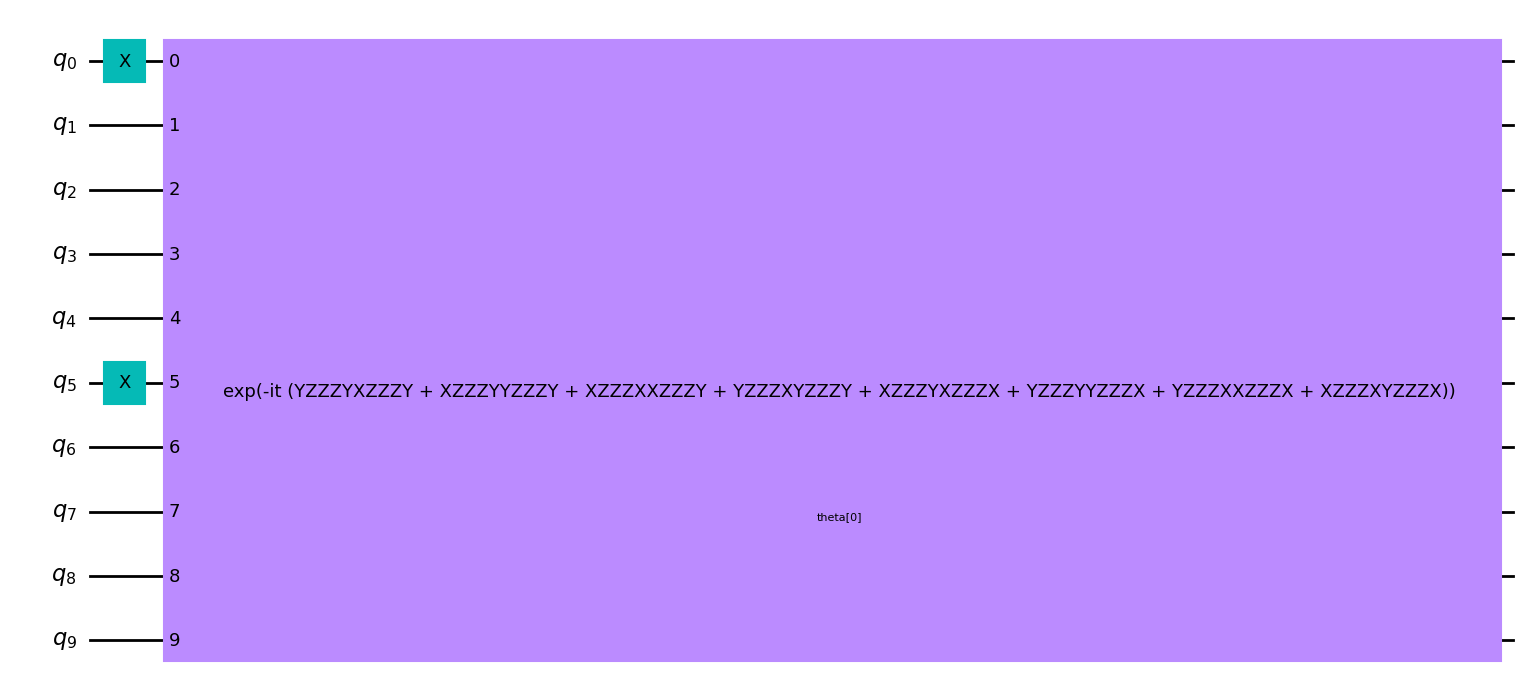

In [24]:
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.synthesis import LieTrotter

ansatz = EvolvedOperatorAnsatz(operators=max_operator, evolution=LieTrotter(), parameter_prefix='theta', initial_state=hf_circuit)
ansatz.decompose().draw(output = 'mpl')

Note that adding an operator to the ansatz does not drain the pool, i.e. the operator we added can again be selected in another iteration.

### Run VQE
We are now ready to run a full VQE on the ansatz that we have so far. We use the cost function and the Estimator primitive as defined above and randomly initiate the parameters to be optimized.

In [25]:
# Random start for the ansatz parameters
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(x0)

[3.83402244]


Now we classically optimize the $\theta_0$ parameter of our ansatz using the ``minimize`` function from ``scipy``.

In [26]:
from scipy.optimize import minimize

res = minimize(cost_func, x0, args=(ansatz, H, estimator), method="cobyla", options={'maxiter': 50, 'disp': True})
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.966906270570856
       x: [ 3.024e+00]
    nfev: 22
   maxcv: 0.0
   Normal return from subroutine COBYLA

   NFVALS =   22   F =-7.966906E+00    MAXCV = 0.000000E+00
   X = 3.024164E+00



## Step 4: Post-process, return result in classical format
We now interpret the results and decide if we need another iteration of the algorithm.

In [29]:
# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = getattr(res, 'fun')
print(f"Found ground energy: {ground_energy}")

# Optimal parameters so far
x_opt =  getattr(res, 'x')
print(x_opt)

Found ground energy: -7.966906270570856
[3.02416384]


In [30]:
gradient_threshold = 1e-3

gradients = compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params=x_opt)
print(gradients)

max_gradient = np.max(np.abs(gradients))
max_index = np.argmax(np.abs(gradients))

print(f"Found maximum gradient {max_gradient} at index {max_index}")
print(f"Maximum gradient is below the threshold: {max_gradient < gradient_threshold}")

[ 0.00707599  0.          0.         -0.00170799  0.00707599  0.
  0.         -0.00170799 -0.01805376  0.          0.          0.07148046
  0.         -0.04085305  0.          0.          0.          0.
 -0.04085305  0.          0.07148046  0.          0.         -0.00025192]
Found maximum gradient 0.07148046043169676 at index 20
Maximum gradient is below the threshold: False


Since the maximum gradient is not below the threshold, we append the operator at the found index to the ansatz.

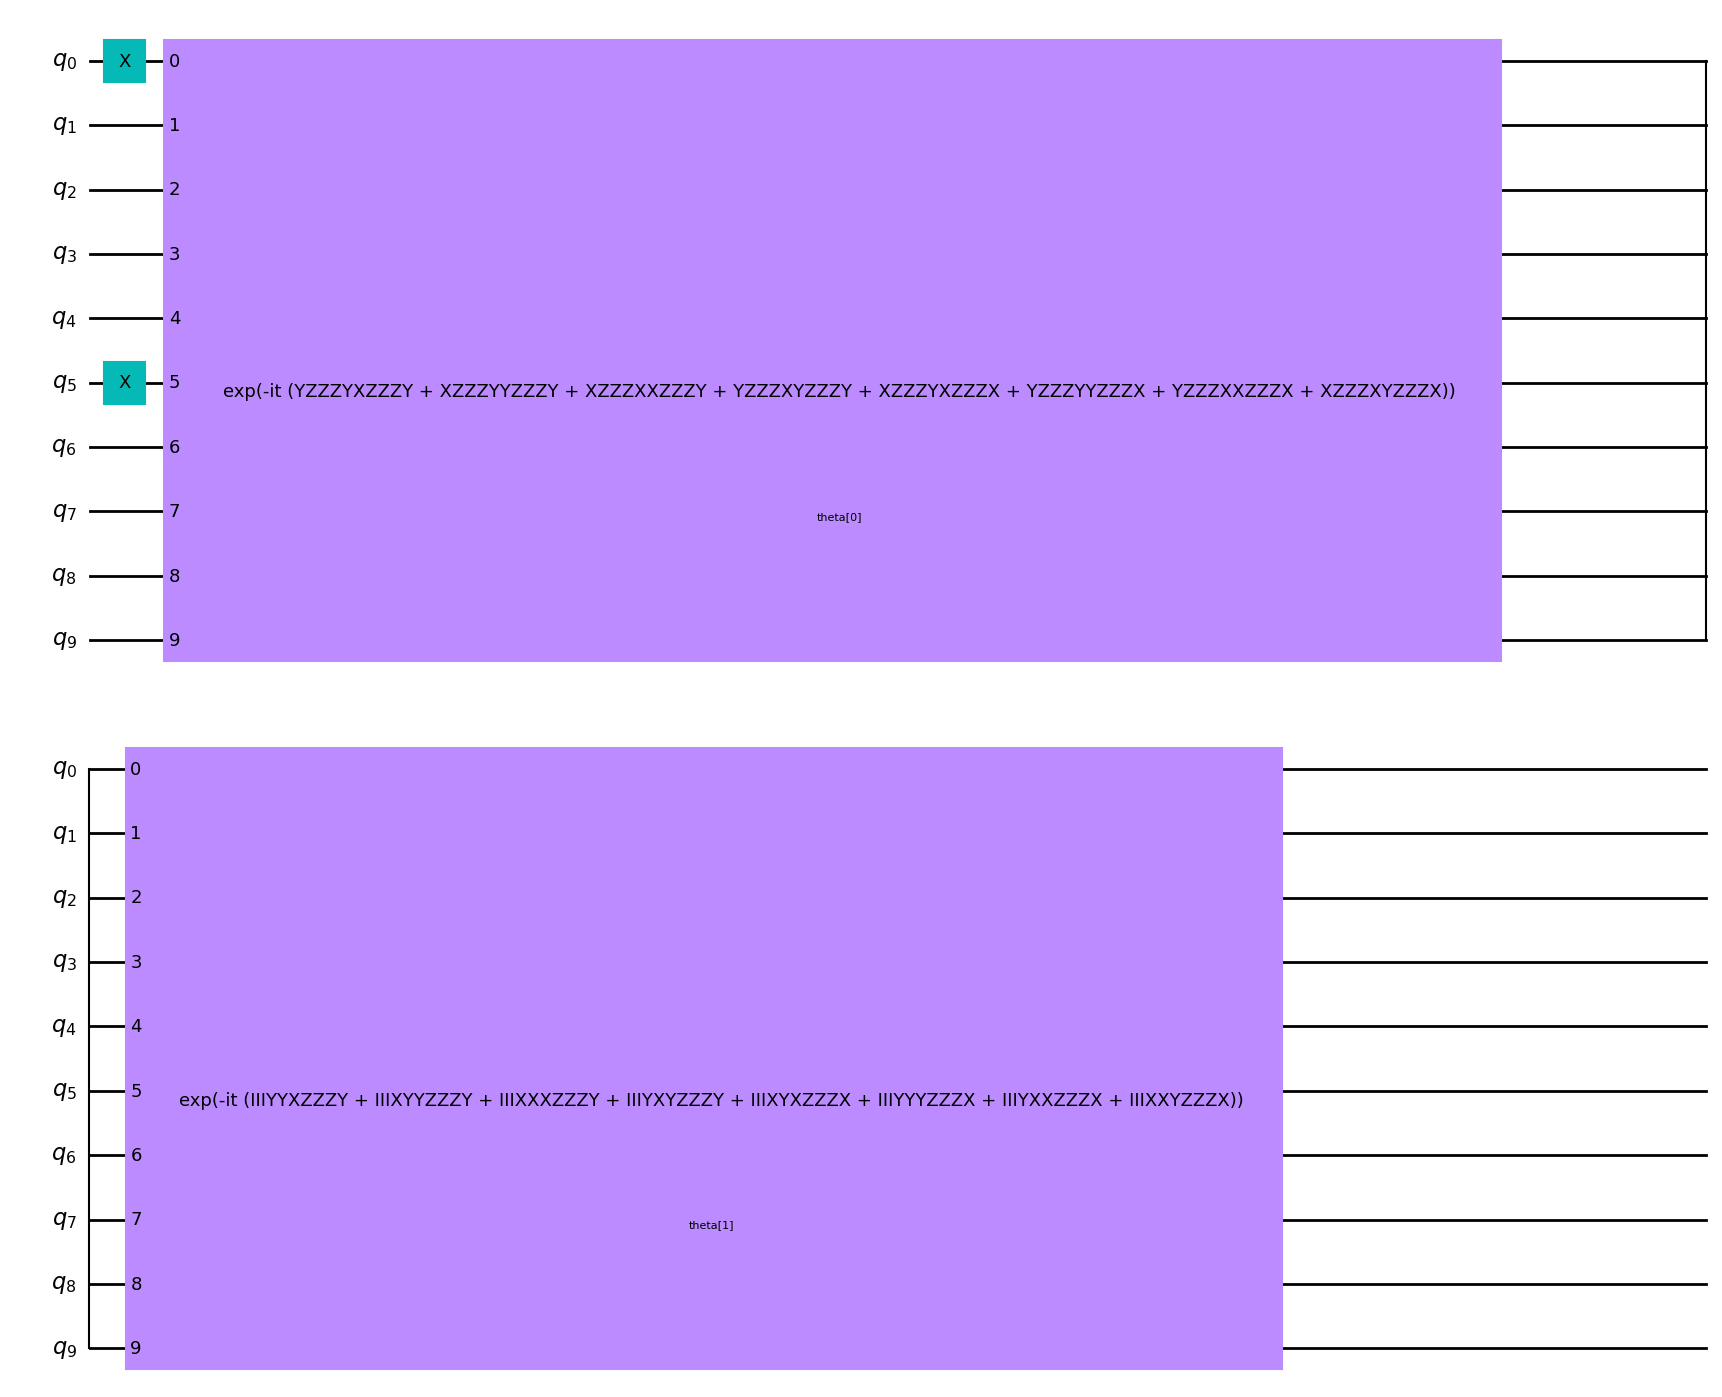

In [31]:
# Initiate the list of operators with the first one 
operator_list = [max_operator]
# Append the second operator
operator_list.append(excitation_pool[max_index])

ansatz = EvolvedOperatorAnsatz(operators=operator_list, evolution=LieTrotter(), parameter_prefix='theta', initial_state=hf_circuit) 
ansatz.decompose().draw(output = 'mpl')

In [32]:
# Random start for the ansatz parameters
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(x0)

res = minimize(cost_func, x0, args=(ansatz, H, estimator), method="cobyla", options={'maxiter': 50, 'disp': True})
print(res)

# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = getattr(res, 'fun')
print(f"Found ground energy: {ground_energy}")

[3.51330317 3.48868114]
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.968684172213385
       x: [ 3.260e+00  3.191e+00]
    nfev: 37
   maxcv: 0.0
   Normal return from subroutine COBYLA

   NFVALS =   37   F =-7.968684E+00    MAXCV = 0.000000E+00
   X = 3.259915E+00   3.191406E+00

Found ground energy: -7.968684172213385


## Putting it all together
Now we automate the algorithm in a single loop.

In [ ]:
from qiskit.primitives import Estimator
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.synthesis import LieTrotter
from scipy.optimize import minimize


# Define the conditions for termination
gradient_threshold = 5e-3
max_iter = 15
terminate = False

# Initiate the problem
ansatz = hf_circuit
hamiltonian = H
excitation_pool = single_excitation_operators + double_excitation_operators
estimator = Estimator()
params = None

iter = 0
operator_list = []
while not terminate:
    print(f"Iter: {iter}")
    gradients = compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params)
    max_gradient = np.max(np.abs(gradients))
    print(f"Maximum gradient: {max_gradient}")
    # Check convergence
    if max_gradient > gradient_threshold:
        # Find the operator with the largest gradient
        max_index = np.argmax(np.abs(gradients))
        max_operator = excitation_pool[max_index]
        print(f"Operator: {max_operator} at index {max_index}")
        # Grow the ansatz
        operator_list.append(max_operator)
        ansatz = EvolvedOperatorAnsatz(operators=operator_list, evolution=LieTrotter(), parameter_prefix='theta', initial_state=hf_circuit)  
        # Run VQE on the current ansatz
        x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
        res = minimize(cost_func, x0, args=(ansatz, H, estimator), method="slsqp", options={'maxiter': 50, 'disp': True})
        print(f"Result at iter {iter}: {getattr(res, 'fun')}")
        x_opt =  getattr(res, 'x')
        params = x_opt
        # Terminate if maximum number of iterations reached
        iter += 1
        if iter >= max_iter:
            print("Terminating: reached maximum iteration.")
            terminate = True
    # Terminate if converged
    else:
        print("Terminating: converged.")
        terminate = True
    
# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = getattr(res, 'fun')
print(f"Found ground energy: {ground_energy}")

In [ ]:
# To continue running on real hardware use
from qiskit_ibm_runtime import Estimator, Session, Options
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.synthesis import LieTrotter
from scipy.optimize import minimize


hf_circuit_ibm = pm.run(hf_circuit)
H_ibm = H.apply_layout(hf_circuit_ibm.layout) 

# Define the conditions for termination
gradient_threshold = 5e-3
max_iter = 15
terminate = False

with Session(backend=backend):
    session_options = Options()
    session_options.execution.shots = 2000
    session_options.resilience_level = 1

    # Initiate the problem
    ansatz = hf_circuit_ibm
    hamiltonian = H_ibm
    excitation_pool = single_excitation_operators + double_excitation_operators
    estimator = Estimator(session=Session(service, backend=backend), options=session_options)
    params = None

    iter = 0
    operator_list = []
    while not terminate:
        print(f"Iter: {iter}")
        excitation_pool_ibm = [exc.apply_layout(ansatz.layout) for exc in excitation_pool]
        gradients = compute_gradients(ansatz, hamiltonian, excitation_pool_ibm, estimator, params)
        max_gradient = np.max(np.abs(gradients))
        print(f"Maximum gradient: {max_gradient}")
        # Check convergence
        if max_gradient > gradient_threshold:
            # Find the operator with the largest gradient
            max_index = np.argmax(np.abs(gradients))
            max_operator = excitation_pool[max_index]
            print(f"Operator: {max_operator} at index {max_index}")
            # Grow the ansatz
            operator_list.append(max_operator)
            ansatz = EvolvedOperatorAnsatz(operators=operator_list, evolution=LieTrotter(), parameter_prefix='theta', initial_state=hf_circuit)  
            ansatz = pm.run(ansatz)
            hamiltonian = H.apply_layout(ansatz.layout) 
            # Run VQE on the current ansatz
            x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
            res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="slsqp", options={'maxiter': 50, 'disp': True})
            print(f"Result at iter {iter}: {getattr(res, 'fun')}")
            x_opt =  getattr(res, 'x')
            params = x_opt
            # Terminate if maximum number of iterations reached
            iter += 1
            if iter >= max_iter:
                print("Terminating: reached maximum iteration.")
                terminate = True
        # Terminate if converged
        else:
            print("Terminating: converged.")
            terminate = True
        
# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = getattr(res, 'fun')
print(f"Found ground energy: {ground_energy}")